In [1]:
import os

In [2]:
imdb_dir = 'data/aclImdb/'
train_dir = os.path.join(imdb_dir,'train')

In [3]:
labels = []
texts = []

In [4]:
for label_type in ['neg','pos']:
    dir_name = os.path.join(train_dir,label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name,fname))
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

In [5]:
len(texts)

25000

In [12]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

In [13]:
maxlen = 100
training_samples = 200
validation_samples = 10000
max_words = 10000

In [14]:
tokenizer = Tokenizer(num_words=max_words)

In [15]:
tokenizer.fit_on_texts(texts)

In [22]:
seq = tokenizer.texts_to_sequences(texts)

In [25]:
len(seq)

25000

In [28]:
word_index = tokenizer.word_index

In [31]:
data = pad_sequences(seq, maxlen=maxlen)

In [44]:
len(seq[6]) , len(data[6])

(61, 100)

In [46]:
labels = np.asarray(labels)

In [47]:
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

Shape of data tensor: (25000, 100)
Shape of label tensor: (25000,)


In [51]:
indices = np.arange(data.shape[0])
np.random.shuffle(indices)

In [52]:
indices

array([21884,  1901,  8365, ..., 11466, 11044,  6299])

In [53]:
data = data[indices]
labels = labels[indices]

In [54]:
x_train = data[:training_samples]
x_val = data[training_samples:training_samples+validation_samples]

y_train = labels[:training_samples]
y_val = labels[training_samples:training_samples+validation_samples]

In [58]:
embedding_index = {}
f = open('data/glove.6B.100d.txt')

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:],dtype='float32')
    embedding_index[word] = coefs
f.close()

In [60]:
len(embedding_index)

400000

In [82]:
embedding_dim = 100
embedding_matrix = np.zeros((max_words,embedding_dim))

In [86]:
for word, i in word_index.items():
    if i < max_words:
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

In [85]:
len(embedding_vector)

100

In [88]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense

In [90]:
model = Sequential()
model.add(Embedding(max_words,embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1,activation='sigmoid'))
model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten (Flatten)            (None, 10000)             0         
_________________________________________________________________
dense (Dense)                (None, 32)                320032    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


In [95]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

In [96]:
model.compile(optimizer='rmsprop',loss='binary_crossentropy',metrics=['acc'])

In [97]:
history = model.fit(x_train, y_train, epochs = 10, batch_size=32, validation_data=(x_val, y_val))

Epoch 1/10
7/7 [==============================] - 6s 229ms/step - loss: 3.1121 - acc: 0.4620 - val_loss: 0.8162 - val_acc: 0.5012
Epoch 2/10
7/7 [==============================] - 1s 153ms/step - loss: 0.5455 - acc: 0.7308 - val_loss: 1.1657 - val_acc: 0.5062
Epoch 3/10
7/7 [==============================] - 1s 149ms/step - loss: 0.6152 - acc: 0.6267 - val_loss: 1.2622 - val_acc: 0.4942
Epoch 4/10
7/7 [==============================] - 1s 165ms/step - loss: 0.3629 - acc: 0.8125 - val_loss: 0.9125 - val_acc: 0.5022
Epoch 5/10
7/7 [==============================] - 1s 162ms/step - loss: 0.1473 - acc: 0.9747 - val_loss: 0.8239 - val_acc: 0.5235
Epoch 6/10
7/7 [==============================] - 1s 192ms/step - loss: 0.2342 - acc: 0.9096 - val_loss: 0.7291 - val_acc: 0.5562
Epoch 7/10
7/7 [==============================] - 1s 169ms/step - loss: 0.0786 - acc: 1.0000 - val_loss: 1.1244 - val_acc: 0.5001
Epoch 8/10
7/7 [==============================] - 1s 150ms/step - loss: 0.0779 - acc: 1.00

In [100]:
train_acc = history.history['acc']
val_acc = history.history['val_acc']

In [102]:
def compare_plots_(train,val,metric):
    import matplotlib.pyplot as plt
    epochs = range(1,len(train)+1)
    plt.plot(epochs,train,'bo',label='Training %s'%(metric))
    plt.plot(epochs,val,'b',label='Validation %s'%(metric))
    plt.title('Training and Validation %s'%(metric))
    plt.legend()
    plt.show()

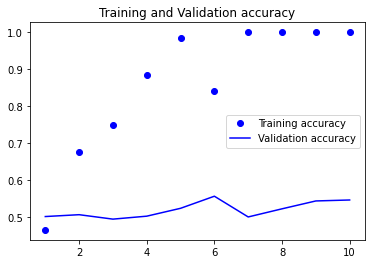

In [103]:
compare_plots_(train_acc,val_acc,'accuracy')